#### Manual testing...

This notebook serves as an integration test to confirm that the model is behaving as we expect.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
MODEL_DIR = os.path.realpath(os.path.dirname('..\superscript_model'))
sys.path.append(os.path.normpath(MODEL_DIR))

In [3]:
from superscript_model import model
from superscript_model.utilities import Random

In [4]:
abm = model.SuperScriptModel(1000)

In [5]:
steps = range(1000)
active_projects = []
team_size = []

for step in steps:
    #print(step)
    abm.step()
    
    size = 0
    active_projects.append(abm.inventory.active_count)
    
    for project in abm.inventory.projects.values():
        size += len(project.team.members)
    team_size.append(size/len(abm.inventory.projects.values()))

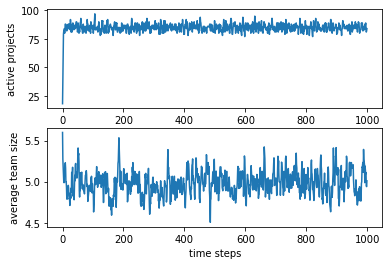

In [6]:
plt.subplot(2,1,1)
plt.plot(steps, active_projects)
plt.ylabel('active projects')

plt.subplot(2,1,2)
plt.plot(steps, team_size)
plt.xlabel('time steps')
plt.ylabel('average team size');

In [7]:
print(np.mean(active_projects[200:]))
print(np.mean(team_size[200:]))

84.99625
4.987984474457608


#### We now select a random worker from the model and inspect the worker:

This produces a json formatted text summary of the worker. Note that this representation will be updated when we add in the worker's history and project activities.

In [8]:
random_worker = Random.choice(abm.schedule.agents)

print(random_worker.skills.to_string())

{
    "Worker OVR": 48.5,
    "Hard skills": [
        1.2,
        3.5,
        0.0,
        1.5,
        3.5
    ],
    "Soft skills": [
        4.3,
        0.7,
        1.7,
        1.5,
        1.6
    ],
    "Hard skill probability": 0.8,
    "OVR multiplier": 20
}


#### We now do the same for a randomly selected project..

In [18]:
random_project = Random.choice(list(abm.inventory.projects.values()))

In [19]:
print(random_project.requirements.to_string())

{
    "risk": 25,
    "creativity": 2,
    "flexible_budget": false,
    "max_budget_increase": 0.25,
    "p_hard_skill_required": 0.8,
    "min_skill_required": 2,
    "per_skill_cap": 10,
    "total_skill_units": 49,
    "hard_skills": {
        "A": {
            "level": 2,
            "units": 10
        },
        "B": {
            "level": 1,
            "units": 9
        },
        "C": {
            "level": 3,
            "units": 10
        },
        "D": {
            "level": 3,
            "units": 10
        },
        "E": {
            "level": 2,
            "units": 10
        }
    }
}


#### For this project we can also inspect the Team:

### Note: here the team of 5 is doing its best to meet the high skill unit requirements...Check with Michael. 

In [20]:
print(random_project.team.to_string())

{
    "project": 19986,
    "members": [
        748,
        976,
        773,
        372,
        340
    ],
    "lead": 748,
    "success_probability": -18.515411868311766,
    "team_ovr": 50.6,
    "skill_balance": 22.6,
    "skill_contributions": {
        "A": [
            976,
            773,
            340,
            748,
            372
        ],
        "B": [
            773,
            976,
            748,
            372,
            340
        ],
        "C": [
            372,
            976,
            748,
            773,
            340
        ],
        "D": [
            773,
            976,
            748,
            372,
            340
        ],
        "E": [
            340,
            976,
            773,
            372,
            748
        ]
    }
}


#### Note that allocating the total skill units across the skills in a robust way was a non-trivial problem! Solved as follows...

*(Move this to another notebook).*

Select 5 numbers in (1,10) that sum to X, where X <=50
Always a = max(a,1) and b = min(b,10)
-	Select n1 randint(a,b) where a = X – (4\*10) and b = X – (4\*1)
-	Select n2 randint(a,b) where a = X – n1 – (3\*10) and b = X – n1 – (3\*1)
-	Select n3 randint(a,b) where a = X – n1 – n2 – (2\*10) and b = X – n1 – n2 – (2\*1)
-	…
-	Select n5 randint(a,b) where a = X – n1 – n2 – n3 – n4 and b = X – n1 – n2 – n3 – n4


In [12]:
def generate_skills(total):

    min_units = 1
    max_units = 10

    remaining = total
    length = 5

    assert total <= length*max_units
    assert total >= length*min_units

    skills = []

    for i in range(length):

        a = remaining - (length - (i+1))*max_units
        a = max(a, min_units)

        b = remaining - (length - (i+1))*min_units
        b = min(b, max_units)

        n = Random.randint(a,b)
        skills.append(n)
        remaining -= n
        
    assert sum(skills) == total
    return skills

In [13]:
for t in np.arange(5,50):
    print(generate_skills(t), "; sum = ", t)

[1, 1, 1, 1, 1] ; sum =  5
[1, 2, 1, 1, 1] ; sum =  6
[2, 2, 1, 1, 1] ; sum =  7
[3, 1, 1, 2, 1] ; sum =  8
[2, 3, 1, 1, 2] ; sum =  9
[4, 2, 2, 1, 1] ; sum =  10
[3, 3, 3, 1, 1] ; sum =  11
[4, 2, 1, 4, 1] ; sum =  12
[1, 2, 3, 2, 5] ; sum =  13
[1, 6, 5, 1, 1] ; sum =  14
[4, 5, 4, 1, 1] ; sum =  15
[4, 3, 1, 4, 4] ; sum =  16
[4, 10, 1, 1, 1] ; sum =  17
[10, 1, 2, 3, 2] ; sum =  18
[8, 3, 2, 5, 1] ; sum =  19
[9, 2, 3, 2, 4] ; sum =  20
[8, 3, 6, 2, 2] ; sum =  21
[7, 3, 3, 6, 3] ; sum =  22
[3, 10, 2, 2, 6] ; sum =  23
[2, 2, 3, 7, 10] ; sum =  24
[1, 6, 7, 10, 1] ; sum =  25
[2, 9, 10, 1, 4] ; sum =  26
[3, 3, 10, 4, 7] ; sum =  27
[2, 5, 4, 9, 8] ; sum =  28
[5, 3, 10, 10, 1] ; sum =  29
[10, 4, 2, 9, 5] ; sum =  30
[6, 3, 6, 10, 6] ; sum =  31
[9, 9, 3, 8, 3] ; sum =  32
[4, 7, 8, 9, 5] ; sum =  33
[6, 4, 4, 10, 10] ; sum =  34
[8, 1, 6, 10, 10] ; sum =  35
[10, 8, 8, 5, 5] ; sum =  36
[10, 8, 3, 6, 10] ; sum =  37
[3, 6, 10, 9, 10] ; sum =  38
[2, 7, 10, 10, 10] ; sum =  39
[8